In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
from utils import generate_train_val_ds, get_image_size
from PIL import Image


In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
train_dir = "/content/drive/My Drive/cervix_cancer_data/train/"
test_dir = "/content/drive/My Drive/cervix_cancer_data/test2_resized/"
val_dir = "/content/drive/My Drive/cervix_cancer_data/val/"
data_dir = "/content/drive/My Drive/cervix_cancer_data/"


In [13]:
random_class = os.listdir(train_dir)[0]
random_image_name = os.listdir(train_dir + random_class)[0]
random_image = Image.open(train_dir + random_class + "/" + random_image_name)
default_image_size = get_image_size(random_image)
default_image_size

256

In [14]:
batch_size = 32
img_height = default_image_size
img_width = default_image_size

In [15]:
train_ds, val_ds = generate_train_val_ds(train_dir, (img_height, img_width), batch_size)

Found 982 files belonging to 3 classes.
Using 786 files for training.
Found 982 files belonging to 3 classes.
Using 196 files for validation.


In [16]:
class_names = train_ds.class_names
class_names

['Type_1', 'Type_2', 'Type_3']

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

KeyboardInterrupt: ignored

<Figure size 720x720 with 0 Axes>

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
# Переводит значения из [0, 255], в [0,1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [29]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     patience=5)


In [32]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stopping_callback]
)

Epoch 1/40
25/25 [==============================] - 3s 98ms/step - loss: 1.5446 - accuracy: 0.4389 - val_loss: 1.0384 - val_accuracy: 0.5102
Epoch 2/40
25/25 [==============================] - 2s 62ms/step - loss: 1.0345 - accuracy: 0.4733 - val_loss: 1.0347 - val_accuracy: 0.5102
Epoch 3/40
25/25 [==============================] - 2s 65ms/step - loss: 1.0238 - accuracy: 0.4809 - val_loss: 1.0335 - val_accuracy: 0.4643
Epoch 4/40
25/25 [==============================] - 2s 62ms/step - loss: 0.9771 - accuracy: 0.4975 - val_loss: 0.9691 - val_accuracy: 0.5357
Epoch 5/40
25/25 [==============================] - 2s 62ms/step - loss: 0.9613 - accuracy: 0.5178 - val_loss: 0.9727 - val_accuracy: 0.4898
Epoch 6/40
25/25 [==============================] - 2s 63ms/step - loss: 0.9590 - accuracy: 0.5178 - val_loss: 0.9537 - val_accuracy: 0.5459
Epoch 7/40
25/25 [==============================] - 2s 62ms/step - loss: 0.9303 - accuracy: 0.5331 - val_loss: 0.9355 - val_accuracy: 0.5561
Epoch 8/40
25

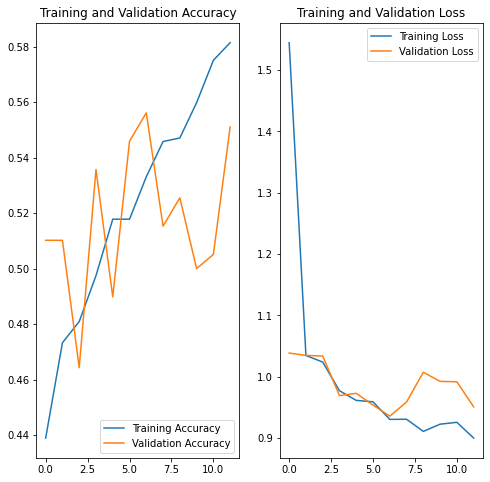

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_image_data_result = pd.DataFrame(columns=["image_name", *class_names])

for image_name in os.listdir(test_dir):
    test_image = tf.keras.utils.load_img(
                        test_dir + image_name, target_size=(img_height, img_width)
                        )
    
    img_array = tf.keras.utils.img_to_array(test_image)
    img_array = tf.expand_dims(img_array, 0)

    test_output = model.predict(img_array)
    
    test_output = tf.nn.softmax(test_output)

    test_output = test_output.numpy().tolist()[0]

    
    temp_dict = dict(zip(class_names, test_output))
    temp_dict["image_name"] = image_name
            
    test_image_data_result.loc[len(test_image_data_result)] = temp_dict

In [ ]:
test_image_data_result.to_csv("submission_tf1.csv", index=False)
# Submission на public score составил 0.938, private - 1.12 
# (в сравнении с torch 0.985 publiс и 0.968 на private)
# стоит отметить, что конфигурации сетей были разные.